# Analysis of catcments and their associated wetland percentage and developed area 4km downstream

By:Elise Boos

Final Project for ENV 859 2022

In [88]:
#Load necessary packages
from pygeohydro import WBD
import pygeohydro as gh
from pynhd import NLDI, WaterData, NHDPlusHR, NHD
import pynhd as nhd
import pandas as pd
import geopandas as gpd
nldi = NLDI()

In [139]:
#Get area of interest

#example for bigger area of interest:
#wbd = WBD("huc4")
#tenn = wbd.byids("huc4", ["0601", "0602"])

#going to do smaller aoi so runs faster

#get huc 12 boundary for cape fear 
wbd = WBD("huc12")
capefear = wbd.byids("huc12", ["030300070307"])

#extract the nhd flowlines within that boundary 
nhd = NHD("flowline_mr")
flow = nhd.bygeom(capefear.geometry[0].bounds)

In [140]:
#extract list of comids for the flowlines within the boundary 
comids = flow['COMID'].tolist()
comids

[10525953,
 10525935,
 10527089,
 10525909,
 10527081,
 10527059,
 10527053,
 10527025,
 10527019,
 10525757,
 10525747,
 10526999,
 10525733,
 10526981,
 10526977,
 10525689,
 10525679,
 10525677,
 10525669,
 10526921,
 10526923,
 10526907,
 10525635,
 10526903,
 10526939,
 10526915,
 10525639,
 10525641,
 10525643,
 10525649,
 10525647,
 10527077,
 10527073,
 10525883,
 10527029,
 10525827,
 10525857,
 10525859,
 10525843,
 10525841,
 10527039,
 10527041,
 10526905,
 10527031,
 10525759,
 10527009,
 10525743,
 10525729,
 10525723,
 10526979,
 10525771,
 10525763,
 10527475,
 10525785,
 10527071,
 10525905,
 10525951,
 10525937,
 10527461,
 10525947,
 10527093,
 10525879,
 10527055,
 10525811,
 10525801,
 10527021,
 10525755,
 10526997,
 10525731,
 10525725,
 10525707,
 10525691,
 10526955,
 10525663,
 10527453,
 10525767,
 10525765,
 10526991,
 10526975,
 10526963,
 10525661,
 10526959,
 10525675,
 10525673,
 10525665,
 10525655,
 10525653,
 10525717,
 10526993,
 10525745,
 10526983,

In [141]:
#create an empty catchment dictionary to store comids and the downstream comids
catchments = {}

In [142]:
#run for loop on comid list to get all catchments/flowlines 4 km downstream
for comid in comids:
    downstream = nldi.navigate_byid(
    fsource="comid",
    fid=str(comid),
    navigation="downstreamMain",
    source="flowlines",
    distance=4,)
    comidsdown = downstream['nhdplus_comid'].tolist()
    catchments[comid] = comidsdown

In [143]:
#observe dictionary
catchments

{10525953: ['10525953', '10527097', '10526039'],
 10525935: ['10525935', '10525953', '10527097'],
 10527089: ['10527089', '10525935', '10525953', '10527097'],
 10525909: ['10525909', '10527089', '10525935', '10525953', '10527097'],
 10527081: ['10527081', '10525909', '10527089'],
 10527059: ['10527059', '10527081'],
 10527053: ['10527053', '10527059', '10527081'],
 10527025: ['10527025', '10527053', '10527059'],
 10527019: ['10527019'],
 10525757: ['10525757', '10527019'],
 10525747: ['10525747', '10525757', '10527019'],
 10526999: ['10526999', '10525747', '10525757', '10527019'],
 10525733: ['10525733', '10526999', '10525747', '10525757'],
 10526981: ['10526981', '10525733', '10526999', '10525747', '10525757'],
 10526977: ['10526977', '10526981', '10525733'],
 10525689: ['10525689', '10526977', '10526981'],
 10525679: ['10525679', '10525689', '10526977', '10526981'],
 10525677: ['10525677', '10525679', '10525689', '10526977'],
 10525669: ['10525669', '10525677', '10525679', '10525689'

In [133]:
#create empty dictionary for wetland percentage and developed area downstream
wetland_per = {}
dev_a_down = {}

In [153]:
#run for loop through all comids to get spatial data on wetlands and developed area 
#developed area add up for all downstream catchments
#wetland percent for the starting catchment 
for key in catchments.keys():
    values = catchments[key]
    devareas = []
    for value in values:
        
        basins = NLDI().get_basins(feature_ids =str(value), fsource = "comid")
        lulc = gh.nlcd_bygeom(basins, 100, years={"cover": [2019]})
        stats = gh.cover_statistics(lulc[str(value)].cover_2019)
        cat = stats.categories
        dev = cat['Developed']
        #project to get meters
        project = basins.to_crs(crs=3857)
        area = project.area
        basin_area = area[str(value)]
        dev_area = (dev/100) * basin_area
        devareas.append(dev_area)
    
    devareasum = sum(devareas)
    dev_a_down[key] = devareasum
    basins = NLDI().get_basins(feature_ids =str(key), fsource = "comid")
    lulc = gh.nlcd_bygeom(basins, 100, years={"cover": [2019]})
    stats = gh.cover_statistics(lulc[str(key)].cover_2019)
    cat = stats.categories
    wet = cat['Wetlands']
    wetland_per[key] = wet


In [154]:
#observe wetland percentages of catchments (comid identifier)
wetland_per

{10483505: 79.9951679149553,
 10525953: 21.936777706557677,
 10525935: 21.932754963354377,
 10527089: 22.369138777454793,
 10525909: 22.31956728005596,
 10527081: 22.176390172976475,
 10527059: 22.060281971739354,
 10527053: 21.940110941239567,
 10527025: 21.885567863253357,
 10527019: 21.854918687060078,
 10525757: 21.52037646708703,
 10525747: 21.44676800761457,
 10526999: 21.357894736842105,
 10525733: 21.2787385261704,
 10526981: 21.47641871724822,
 10526977: 21.33061924148275,
 10525689: 21.28154539297388,
 10525679: 21.22620606800658,
 10525677: 21.203040130910956,
 10525669: 21.21020492856155,
 10526921: 21.00604662264301,
 10526923: 21.31359234108872,
 10526907: 21.262883704219345,
 10525635: 21.116715754313507,
 10526903: 21.151831268221574,
 10526939: 19.313142749315972,
 10526915: 17.55068605365554,
 10525639: 17.21476510067114,
 10525641: 16.656980123212833,
 10525643: 16.131676000546374,
 10525649: 16.64025356576862,
 10525647: 16.171224732461358,
 10527077: 22.94322132097

In [155]:
#observe developed area (in m^2) 4 km downstream of catchments (comid identifier)
dev_a_down

{10483505: 0.17501986837206962,
 10525953: 505323681.8118132,
 10525935: 485602392.17866087,
 10527089: 634007159.8337078,
 10525909: 781428541.6687938,
 10527081: 425296524.53949,
 10527059: 258887970.6250381,
 10527053: 388156041.75584805,
 10527025: 386945139.37691873,
 10527019: 128368903.85464324,
 10525757: 238259559.2289002,
 10525747: 347764796.1627216,
 10526999: 455455537.30901337,
 10525733: 434449048.44856036,
 10526981: 541667836.8789631,
 10526977: 321992983.08426577,
 10525689: 322061241.223159,
 10525679: 429288613.6669464,
 10525677: 429221524.5935138,
 10525669: 429193659.6836025,
 10526921: 535043111.4273513,
 10526923: 412394182.8601264,
 10526907: 503009675.9276655,
 10525635: 485858276.02180785,
 10526903: 576469852.8781334,
 10526939: 228077971.5410264,
 10526915: 28953885.642286673,
 10525639: 42441844.08067671,
 10525641: 55535606.18852025,
 10525643: 66667224.28372592,
 10525649: 62267549.26122098,
 10525647: 43623935.61683004,
 10527077: 800391764.9708117,
 1

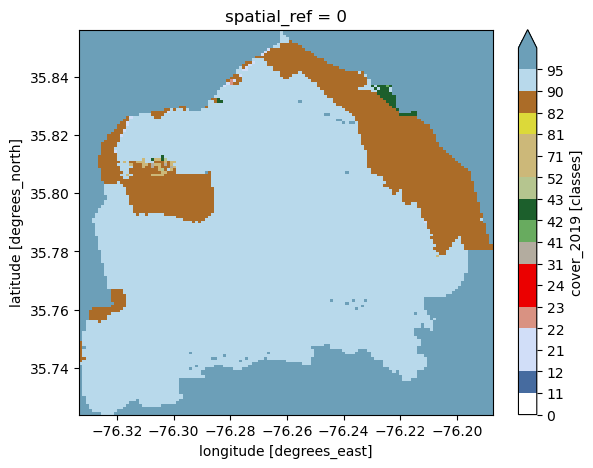

In [166]:
#example map of nlcd for a catchemnt with HIGH wetland percent 
basins = NLDI().get_basins(feature_ids ='10483505', fsource = "comid")
lulc = gh.nlcd_bygeom(basins, 100, years={"cover": [2019]})
cmap, norm, levels = gh.plot.cover_legends()
ax = lulc['10483505'].cover_2019.plot(
    size=5, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]} )

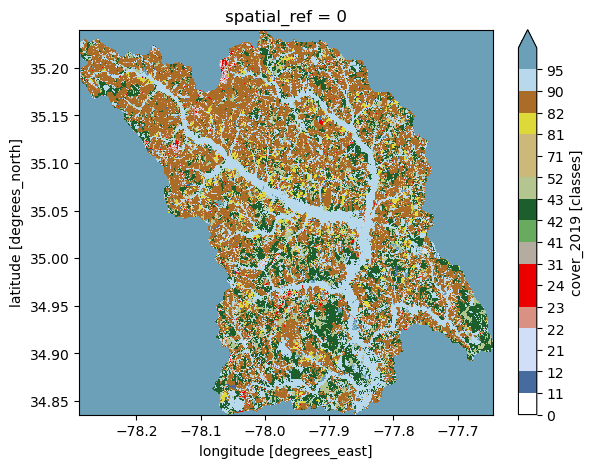

In [174]:
#example map of nlcd for a catchemnt with a MODERATE (21 per) wetland percentage and HIGH downstream developed area
basins = NLDI().get_basins(feature_ids ='10525909', fsource = "comid")
lulc = gh.nlcd_bygeom(basins, 100, years={"cover": [2019]})
cmap, norm, levels = gh.plot.cover_legends()
ax = lulc['10525909'].cover_2019.plot(
    size=5, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]} ) 